# Depth estimation

## Depth from disparity using [8 point algorithm](https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html) 
double check link^

In [1]:
# Imports
import numpy as np
import cv2  
import matplotlib.pyplot as plt

In [2]:
# Select 2 images for feature matching
img1 = cv2.imread('../data/tornado_frame_groups/frames_0/Seimon_4K_calibrated_2024_corrected_81705.png')
img2 = cv2.imread('../data/tornado_frame_groups/frames_0/Schyma_4K_calibrated_81705.png')

In [3]:
# Code for manually collecting points in images (CP)

# Define the callback function
def get_pixel_coordinates(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Check if the left mouse button was clicked
        print(f"Pixel coordinates: ({x}, {y})")

# Read the image
img = img1

# Display the image in a window
cv2.namedWindow('Image', cv2.WINDOW_NORMAL)
cv2.imshow('Image', img)

# Resize the window to fit the whole image but be in a smaller panel
height, width = img.shape[:2]
cv2.resizeWindow('Image', width // 2, height // 2)

# Set the mouse callback function to get_pixel_coordinates
cv2.setMouseCallback('Image', get_pixel_coordinates)

# Wait until a key is pressed
cv2.waitKey(0)

# Destroy all windows
cv2.destroyAllWindows()

Feature matching

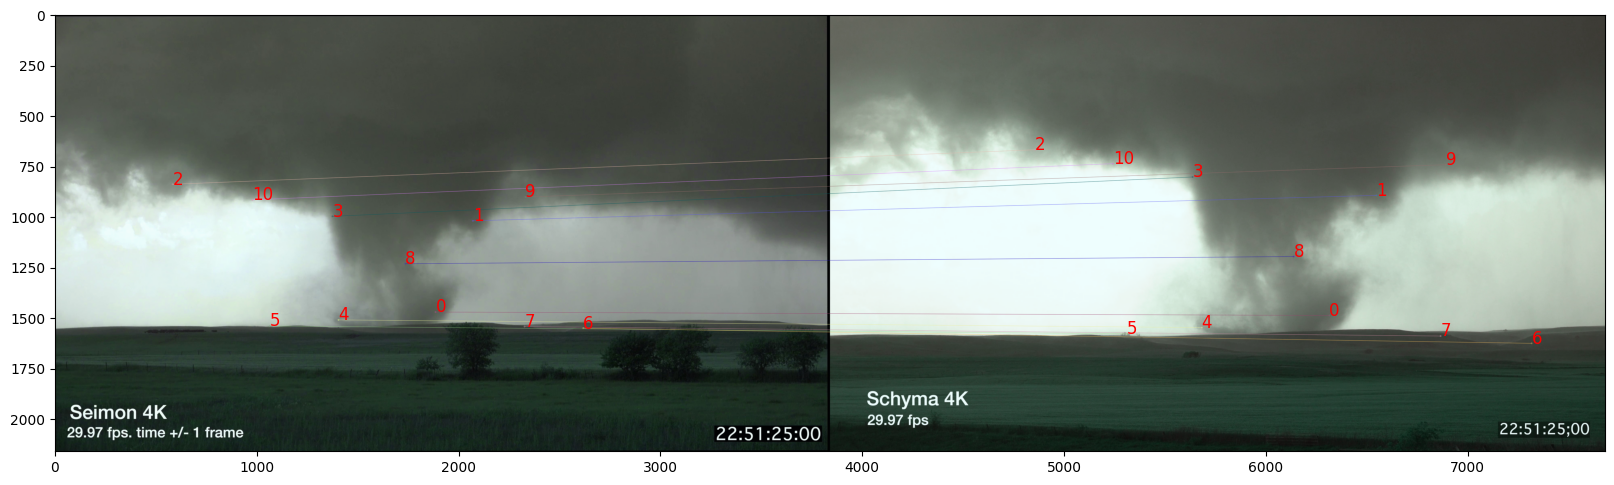

In [4]:
# Collected points
pts1 = [(1885, 1471), (2070, 1019), (582, 838), (1374, 997), (1404, 1510), (1063, 1540), (2617, 1551), (2326, 1543), (1735, 1232), (2331, 901), (978, 915)]
pts2 = [(2474, 1488), (2707, 893), (1017, 667), (1796, 802), (1842, 1548), (1472, 1579), (3476, 1626), (3025, 1590), (2297, 1196), (3051, 741), (1401, 736)]

# Convert points to numpy arrays
pts1 = np.array(pts1)
pts2 = np.array(pts2)

# Find the fundamental matrix using the 8-point algorithm
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)

# Draw the matches between the images
img_matches = cv2.drawMatches(img1, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts1], 
                              img2, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts2], 
                              [cv2.DMatch(i, i, 0) for i in range(len(pts1))], None)

# Display the matches
plt.figure(figsize=(20, 10))
plt.imshow(img_matches)

# Annotate the points with their index numbers
for i, (pt1, pt2) in enumerate(zip(pts1, pts2)):
    plt.text(pt1[0], pt1[1], str(i), color='red', fontsize=12)
    plt.text(pt2[0] + img1.shape[1], pt2[1], str(i), color='red', fontsize=12)

plt.show()


In [5]:
# Camera intrinsic estimation
k1 = np.array([[1000.0, 0.0, img1.shape[0]//2], [0.0, 1000, img1.shape[1]//2], [0.0, 0.0, 1.0]])
k2 = np.array([[1000.0, 0.0, img1.shape[0]//2], [0.0, 1000, img1.shape[1]//2], [0.0, 0.0, 1.0]])

# Essential matrix
E = k2.T @ F @ k1

# Rotation and translation matrix
_, R, T, mask = cv2.recoverPose(E, pts1, pts2)

# Calculating disparity
disparity = []
for i in range(len(pts1)):
    disparity.append(np.linalg.norm(pts1[i][0] - pts2[i][0]))

    # Normalize disparity
disparity = np.array(disparity)
disparity = (disparity - disparity.min()) / (disparity.max() - disparity.min())

Show point-wise disparity

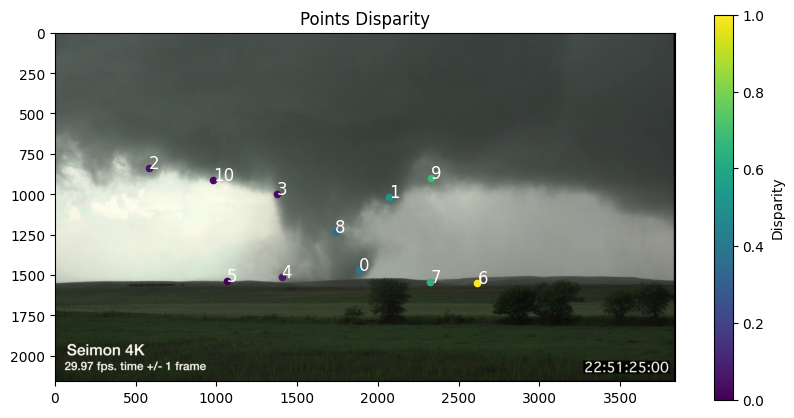

In [6]:
# Create a colormap
colormap = plt.cm.viridis

# Plot the points on the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

for i, (pt, depth) in enumerate(zip(pts1, disparity)):
    color = colormap(depth)  # Get the color from the colormap
    plt.scatter(pt[0], pt[1], color=color, s=20)  # Plot the point with the corresponding color
    plt.text(pt[0], pt[1], str(i), color='white', fontsize=12)  # Annotate the point with its index

plt.colorbar(label='Disparity', shrink=0.5)
plt.title('Points Disparity')
plt.show()

## Point triangulation in 3D space

In [8]:
# Triangulate points
points_4d_hom = cv2.triangulatePoints(k1 @ np.hstack((np.eye(3), np.zeros((3, 1)))), 
                                      k2 @ np.hstack((R, T)), 
                                      pts1.T, pts2.T)

# Convert homogeneous coordinates to 3D
points_3d = points_4d_hom[:3] / points_4d_hom[3]

# Transpose to get Nx3 shape
points_3d = points_3d.T

print("3D Points:\n", points_3d)

3D Points:
 [[ 1.96032769 -1.00457293 -1.00374178]
 [-0.73445478  1.43321804  0.09689319]
 [ 1.96032769 -1.00457293 -1.00374178]
 [-0.73445478  1.43321804  0.09689319]
 [ 1.96032769 -1.00457293 -1.00374178]
 [-0.73445478  1.43321804  0.09689319]
 [ 1.96032769 -1.00457293 -1.00374178]
 [-0.73445478  1.43321804  0.09689319]
 [ 1.96032769 -1.00457293 -1.00374178]
 [-0.50148696 -0.44265154  0.8810826 ]
 [-1.3482869   0.69072359  0.69041762]]


## Generating disparity map (independent from workflow above)
split into new notebook?

(np.float64(-0.5), np.float64(3839.5), np.float64(1859.5), np.float64(-0.5))

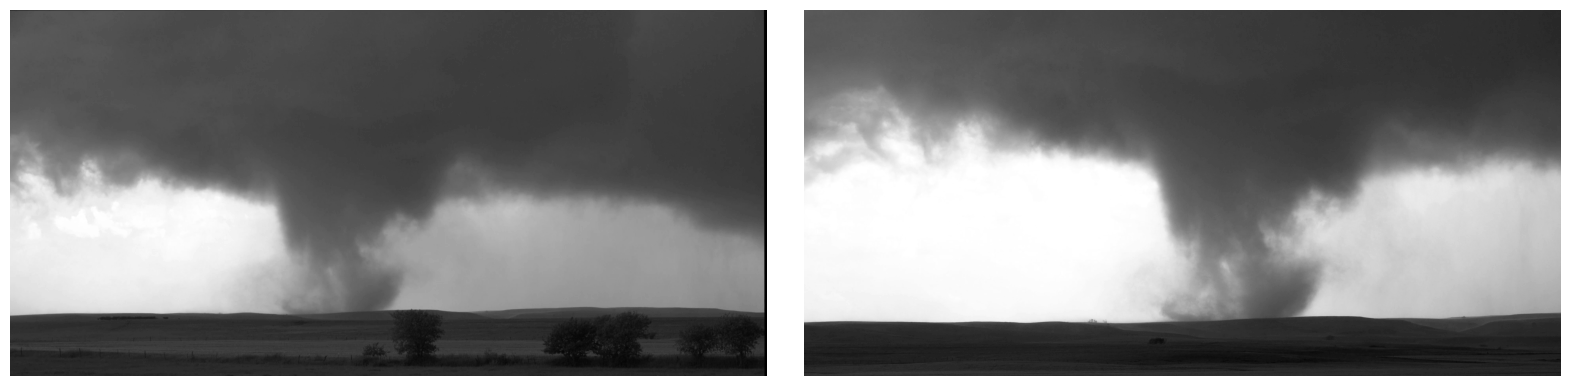

In [9]:
import cv2
import numpy as np
# Load the stereo images (left and right)
img_left = cv2.imread('../data/tornado_frame_groups/frames_0/Seimon_4K_calibrated_2024_corrected_81705.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('../data/tornado_frame_groups/frames_0/Schyma_4K_calibrated_81705.png', cv2.IMREAD_GRAYSCALE)
img_left = img_left[0:-300, :]
img_right = img_right[0:-300, :]

# # Convert points to numpy arrays
# pts1 = np.array(pts1)
# pts2 = np.array(pts2)

# Stereo calibration data (example values; replace with actual calibration results)
K1 = np.array([[1000.0, 0.0, img1.shape[0]//2], [0.0, 1000, img1.shape[1]//2], [0.0, 0.0, 1.0]])
K2 = np.array([[1000.0, 0.0, img1.shape[0]//2], [0.0, 1000, img1.shape[1]//2], [0.0, 0.0, 1.0]])
D1 = np.zeros(5)  # Distortion for left camera
D2 = np.zeros(5)  # Distortion for right camera
R = np.eye(3)  # Rotation matrix between cameras
T = np.array([0.1, 0, 0])  # Translation vector between cameras
# Perform stereo rectification
image_size = img_left.shape[::-1]  # (width, height)
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(K1, D1, K2, D2, image_size, R, T, flags=cv2.CALIB_ZERO_DISPARITY)
# Compute rectification maps
map1x, map1y = cv2.initUndistortRectifyMap(K1, D1, R1, P1, image_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K2, D2, R2, P2, image_size, cv2.CV_32FC1)
# Rectify the images
rectified_left = cv2.remap(img_left, map1x, map1y, cv2.INTER_LINEAR)
rectified_right = cv2.remap(img_right, map2x, map2y, cv2.INTER_LINEAR)
# Display rectified 

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.05)  # Reduce the margin between images
axs[0].imshow(img_left, cmap='gray')
axs[0].axis('off')  # Remove axis
axs[1].imshow(img_right, cmap='gray')
axs[1].axis('off')  # Remove axis


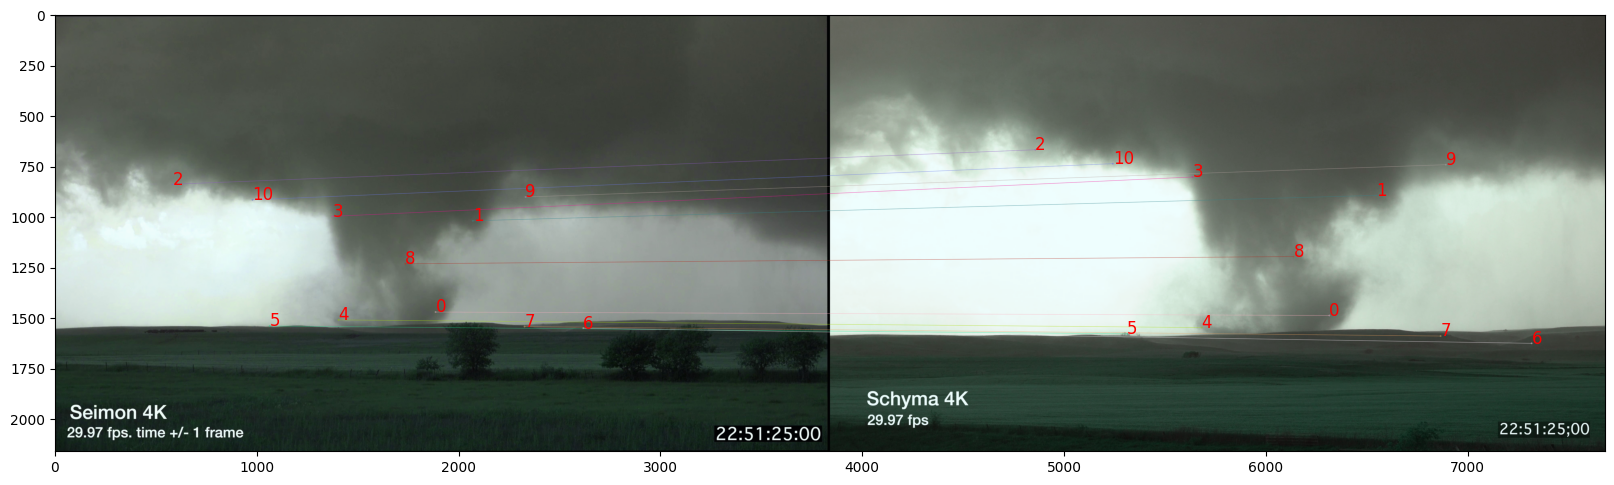

In [ ]:
# Draw the matches between the images
img_matches = cv2.drawMatches(img1, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts1], 
                              img2, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts2], 
                              [cv2.DMatch(i, i, 0) for i in range(len(pts1))], None)

# Display the matches
plt.figure(figsize=(20, 10))
plt.imshow(img_matches)

# Annotate the points with their index numbers
for i, (pt1, pt2) in enumerate(zip(pts1, pts2)):
    plt.text(pt1[0], pt1[1], str(i), color='red', fontsize=12)
    plt.text(pt2[0] + img1.shape[1], pt2[1], str(i), color='red', fontsize=12)

plt.show()

Text(0.5, 1.0, 'Disparity')

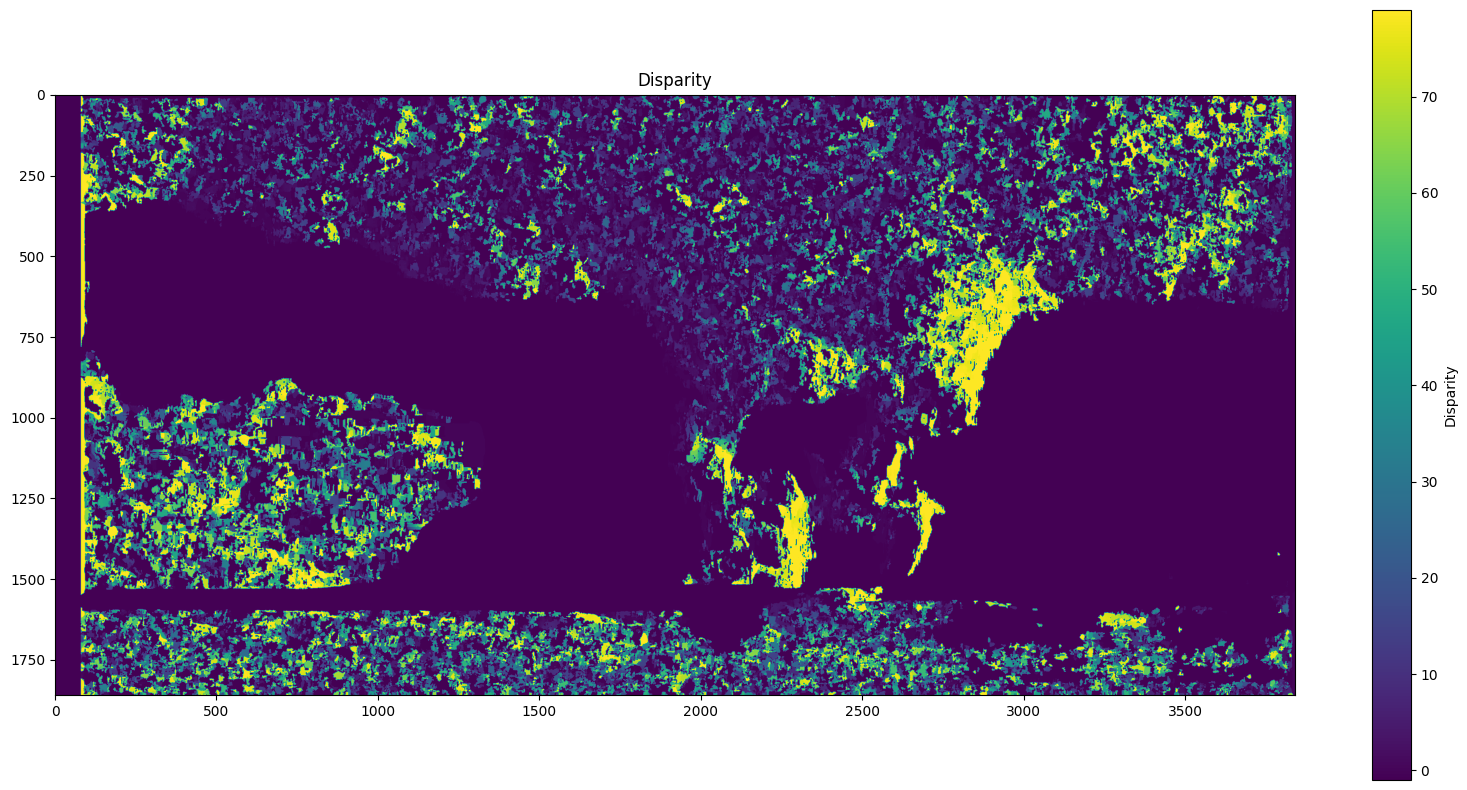

In [11]:
# Proceed with disparity computation (unchanged from previous code)
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16 * 5,
    blockSize=25,
    P1=8 * 3 * 25 ** 2,
    P2=32 * 3 * 25 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=50,
    speckleRange=32
)
disparity = stereo.compute(rectified_left, rectified_right).astype(np.float32) / 16.0
plt.figure(figsize=(20, 10))
plt.imshow(disparity, cmap='viridis')

plt.colorbar(label='Disparity')
plt.title("Disparity")


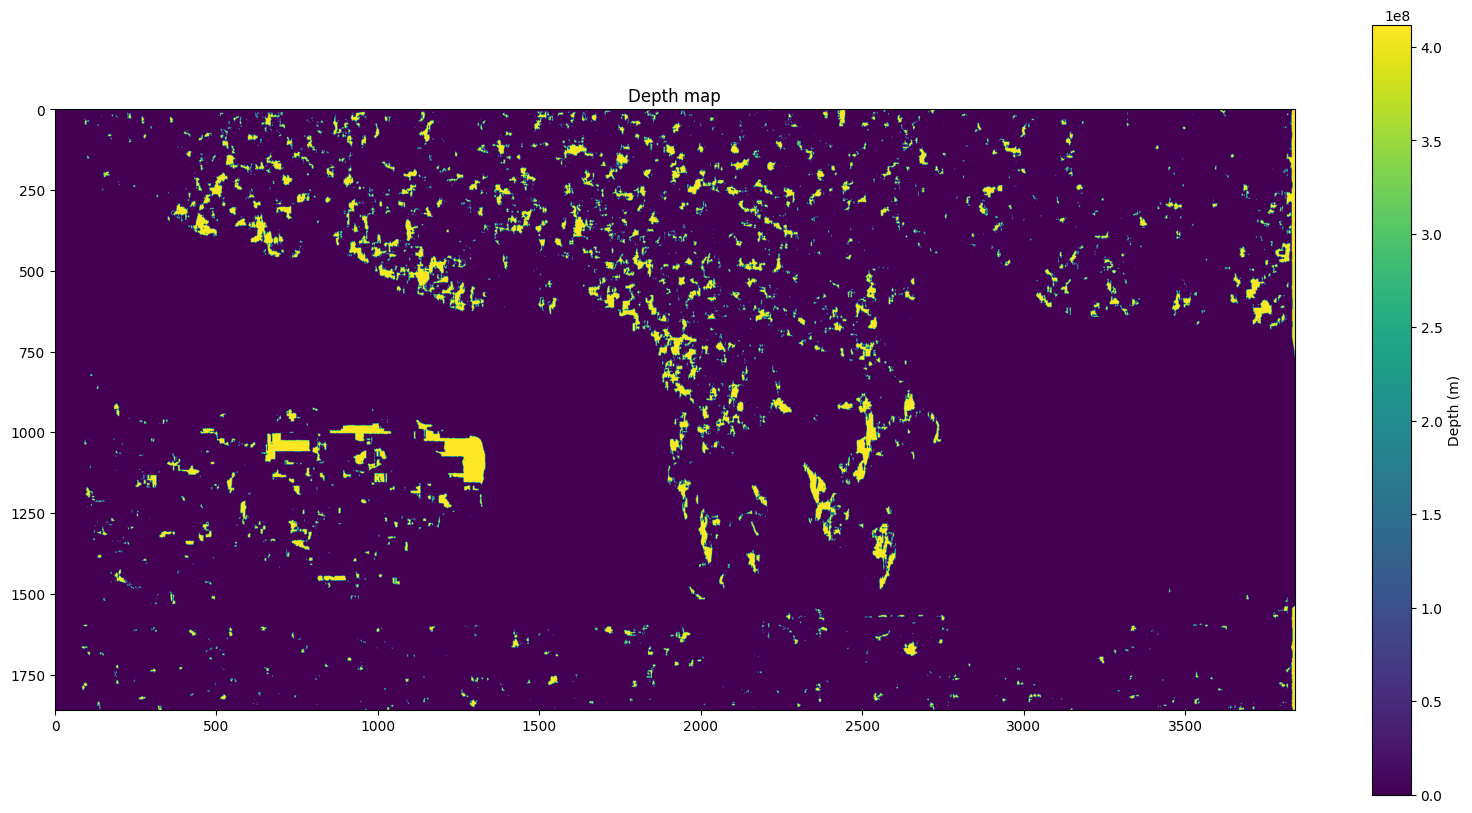

In [14]:
# Calculate depth using the disparity map and the translation vector T
focal_length = K1[0, 0]  # Assuming the focal length is the same for both cameras
baseline = np.linalg.norm(T)  # Distance between the two camera centers

known_distance = 412.02

baseline = baseline*known_distance
# Avoid division by zero by setting disparity values of zero to a small number
disparity[disparity == 0] = 0.0001
# Calculate depth
depth_map = (focal_length * baseline) / disparity

# Display the depth heatmap
plt.figure(figsize=(20, 10))
plt.imshow(depth_map, cmap='viridis')
plt.title("Depth map")
plt.colorbar(label='Depth (m)')
plt.show()